# AML flow cytometry analysis

In [1]:
import numpy as np
import torch
from torch.autograd import Variable
from fcvae_dataset import load_data
from fcvae_model import VAE, Encoder, Decoder, Classifier
from fcvae_trainer import fcTrainer
from fcvae_plot import CellPlotter2D, plot_joint_aml, plot_shared_markers_aml, plot_imputed_values
from umap import UMAP
import flowkit as fk
import glob

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Torch version:", torch.__version__)
print("Device:", device)

Torch version: 1.2.0
Device: cpu


## 1. Load data

In [2]:
filepath1 = "/scratch/cs/csb/projects/single-cell-analysis/FCM/AML_FCM/data_files/"

batch_size = 256         # number of data points in each batch
n_epochs = 5           # times to run the model on complete data
input_dim = 7     # size of each input
hidden_dim = 128        # hidden dimension
latent_dim = 4        # latent vector dimension
lr = 1e-3              # learning rate
n_head = 2
n_shared = 3
missing = 4

datasets = load_data(filepath1)

input_dim_list = []
output_dim_list = []
train_iterators = []
test_iterators = []
train_cells = 0
test_cells = 0
for tube in datasets:
    input_dim_list.append(len(tube[0].columns))
    output_dim_list.append(len(tube[0].columns)+missing)
    train_iterators.append(tube[3])
    test_iterators.append(tube[4])
    train_cells += tube[1].nb_cells
    test_cells += tube[2].nb_cells

N_train = int(train_cells/n_head)
N_test = int(test_cells/n_head)
print('Training set size:', N_train)
print('Test set size:', N_test)

Training set size: 27000
Test set size: 3000


## 2. Create a model

In [3]:
# Encoder
encoder = Encoder(n_head, input_dim_list, hidden_dim, latent_dim)

# Decoder
decoder = Decoder(latent_dim, hidden_dim, output_dim_list, n_head)

# VAE
model = VAE(encoder, decoder).to(device)

# Discriminator
discriminator = Classifier(latent_dim, hidden_dim, n_head) 

print("n_tubes:", n_head)
print("n_shared:", n_shared)
print("n_other:", missing)
print("output_dim:", output_dim_list[0])
print("encoder_dims:", input_dim_list)

n_tubes: 2
n_shared: 3
n_other: 4
output_dim: 11
encoder_dims: [7, 7]


## 3. Train the model

In [4]:
# Create trainer
trainer = fcTrainer(
            model,
            discriminator,
            train_loaders = train_iterators,
            test_loaders = test_iterators,
            N_train = N_train,
            N_test = N_test,
            device = device,
            n_epochs = n_epochs,
            print_frequency = 1,
            optimizer_kwargs = dict(lr = lr)
)

28/02/2020 17:06:55 [INFO]: Creating a trainer on device `cpu`


In [5]:
# Run training
trainer.train()

28/02/2020 17:06:55 [INFO]: TRAINING STARTED (n_epochs = 5).
28/02/2020 17:07:12 [INFO]: Epoch: 0, VAE loss: (65.32516, 28.79575), Discriminator loss: (0.58872, 0.83535)
28/02/2020 17:07:29 [INFO]: Epoch: 1, VAE loss: (34.24883, 23.12265), Discriminator loss: (0.26617, 0.89042)
28/02/2020 17:07:46 [INFO]: Epoch: 2, VAE loss: (30.90386, 23.18605), Discriminator loss: (0.32572, 0.99482)
28/02/2020 17:08:03 [INFO]: Epoch: 3, VAE loss: (28.47551, 21.56594), Discriminator loss: (0.49845, 0.99911)
28/02/2020 17:08:20 [INFO]: Epoch: 4, VAE loss: (27.11695, 20.23679), Discriminator loss: (0.61238, 1.05462)
28/02/2020 17:08:20 [INFO]: TRAINING FINISHED.



## 4. Visualization

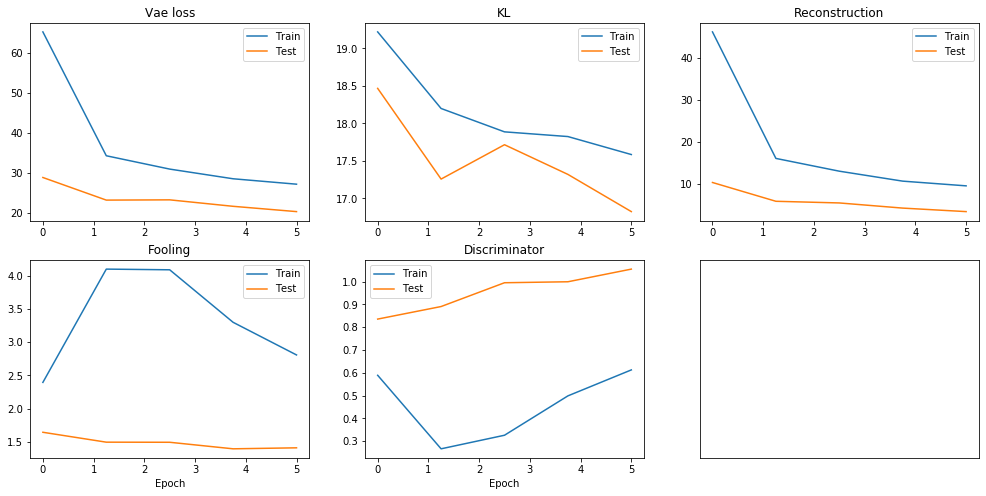

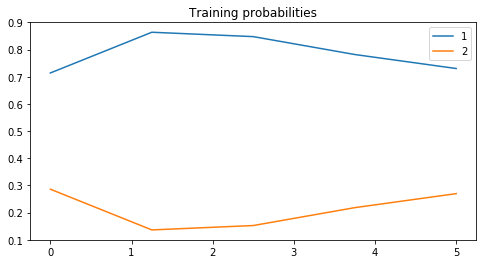

In [6]:
trainer.plot()
trainer.plot_probs()

/home/hiltunh3/.conda/envs/scvi/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../home/hiltunh3/.conda/envs/scvi/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/home/hiltunh3/.conda/envs/scvi/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../.

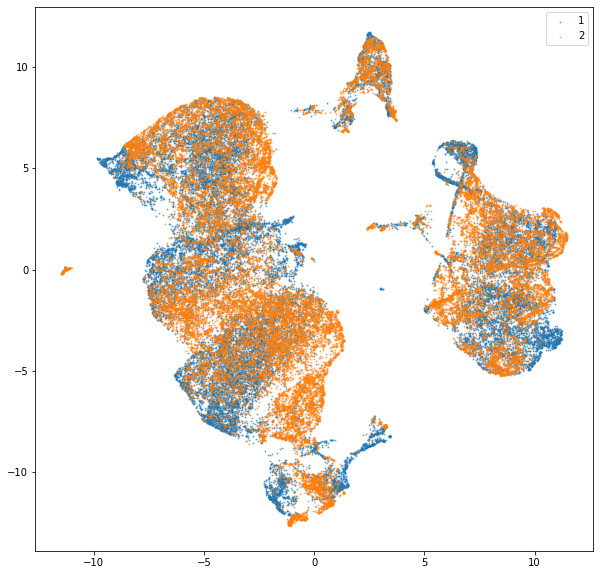

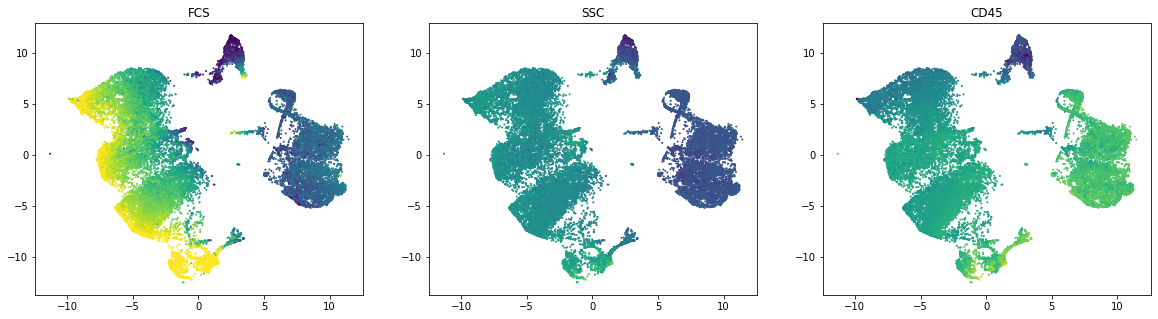

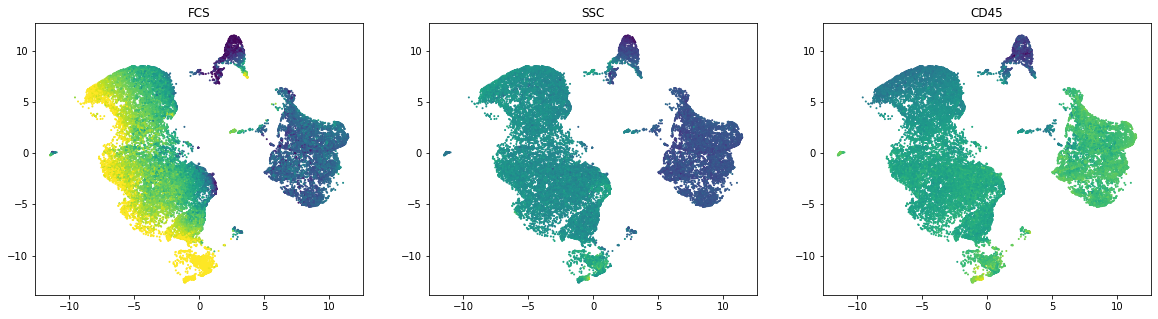

In [7]:
latents = []

trainer.vae.eval()
for i in range(n_head):
    data = Variable(torch.from_numpy(datasets[i][0].to_numpy()), requires_grad=False)
    latents.append(model.get_z(data.float(), i).data.numpy())
latent2d = UMAP().fit_transform(np.concatenate(latents))

plot_joint_aml(trainer, latent2d, latents)
plot_shared_markers_aml(trainer, latent2d, latents, datasets)

## 5. Imputation

/home/hiltunh3/.conda/envs/scvi/lib/python3.6/site-packages/flowio/flowdata.py:275: UserWarning: text in segment does not start and end with delimiter
  warn("text in segment does not start and end with delimiter")


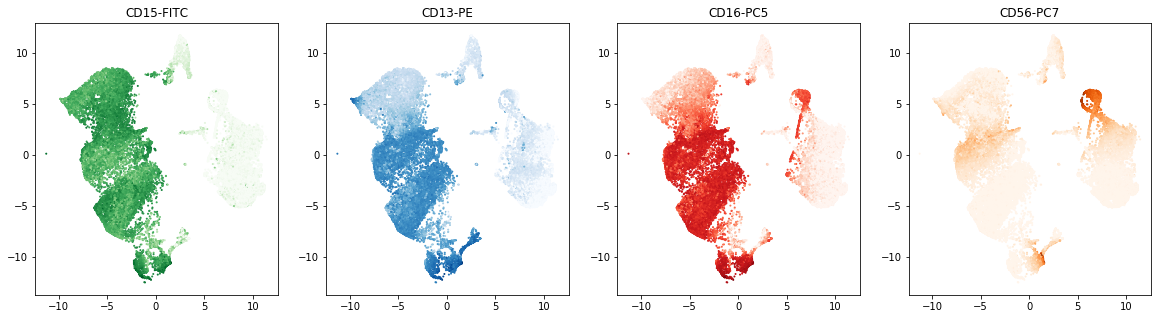

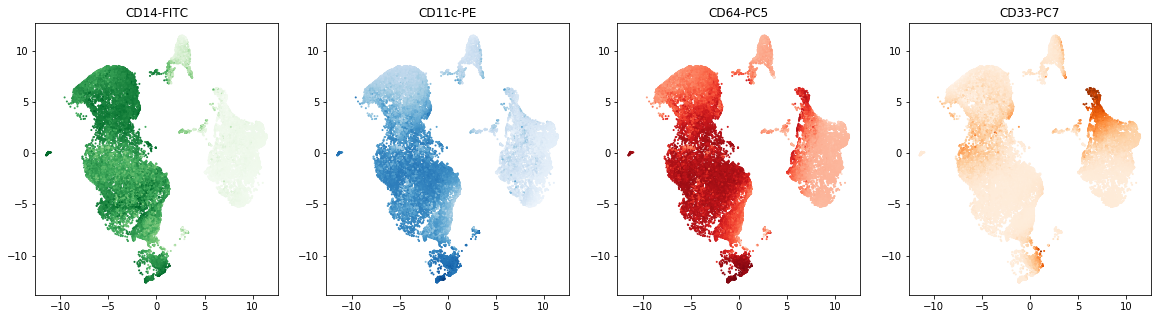

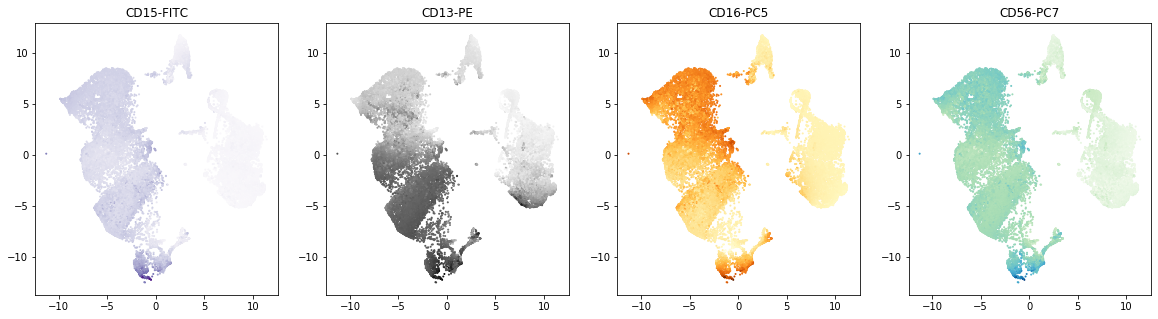

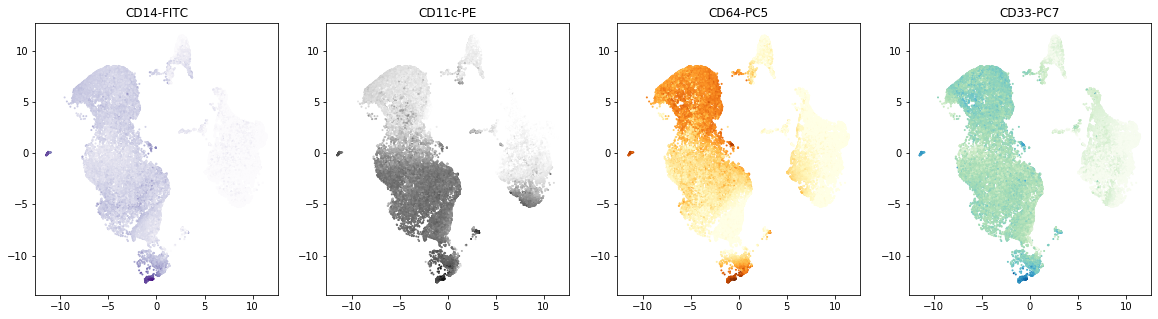

In [8]:
# marker names 
files = glob.glob(filepath1 + "*.txt")
titles = []
for i in range(len(files)):
    fcs = files[i][-8:-4]
    fcs_path = '/scratch/cs/csb/projects/single-cell-analysis/FCM/AML_FCM/Data/AML/FCS/'+fcs+'.FCS'
    sample = fk.Sample(fcs_path, subsample_count=None)
    features = sample.pns_labels[2:7]
    features.pop(2)
    titles.append(features)
 
# visualize one set of imputed values
plot_imputed_values(trainer, latent2d, latents, datasets, titles)

In [ ]:
# Comparison: run 10 times, accuracy and log p(y)?